In [ ]:
print("Connecting to Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("Drive connected.")

Connecting to Google Drive...
Mounted at /content/drive
Drive connected.


In [ ]:
# STEP 1: SETUP AND INSTALLATIONS
# ==============================================================================
# Installs the necessary library in your Colab/Jupyter environment.
!pip install rasterio pandas

import pandas as pd
import numpy as np
import rasterio
from rasterio.windows import Window
import json
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.2 MB/s eta 0:00:00


In [24]:
# STEP 2: CONFIGURATION - SET YOUR FILE PATHS
# ==============================================================================
# ---!!! IMPORTANT: YOU MUST UPDATE THESE THREE PATHS !!!---

# 1. The path to your LARGE satellite image GeoTIFF file.
full_image_path = '/content/drive/My Drive/Singrauli_uncertainity/Singrauli_Merged_Image.tif'

# 2. The path to your SMALL CSV file containing the coordinates and class labels.
points_csv_path = '/content/drive/My Drive/Singrauli_uncertainity/Singrauli.csv'

# 3. Path and filename for the NEW file we will create to store the processed data.
processed_data_path = '/content/drive/My Drive/GEE_Exports/cnn_prepared_patches.npz'

# Define the size of the square patches you want to create (e.g., 10x10 pixels)
PATCH_SIZE = 10

In [25]:
# STEP 3: FUNCTION TO EXTRACT THE PATCHES
# ==============================================================================
def create_patch_dataset(image_path, csv_path, patch_size):
    """
    Uses a CSV of point coordinates to extract image patches from a large GeoTIFF.

    Returns:
        A tuple of (numpy.ndarray, numpy.ndarray): (image_patches, labels)
    """
    try:
        points_df = pd.read_csv(csv_path)
        src_image = rasterio.open(image_path)
    except FileNotFoundError as e:
        print(f"ERROR: A file was not found. Please check your paths. Details: {e}")
        return None, None

    print(f"Loaded {len(points_df)} training point locations.")
    print(f"Image has {src_image.count} bands.")

    X_patches = []  # To store the image patch data (numpy arrays)
    y_labels = []   # To store the class labels

    print(f"\nExtracting {patch_size}x{patch_size} patches... (This can be slow)")

    # Loop through each point in the CSV file
    for index, row in points_df.iterrows():
        try:
            # Use the direct latitude and longitude columns from your CSV
            lon = row['longitude']
            lat = row['latitude']
            label = row['class']

            # Convert the geographic coordinate (lon, lat) to pixel coordinate (col, row)
            py, px = src_image.index(lon, lat)

            # Define the window to read around the center pixel
            window = Window(px - patch_size // 2, py - patch_size // 2, patch_size, patch_size)

            # Read the data from the image window (this is the patch)
            patch = src_image.read(window=window)

            # Ensure the patch has the correct dimensions
            if patch.shape[1] == patch_size and patch.shape[2] == patch_size:
                # Re-order axes from (bands, height, width) to (height, width, bands)
                patch = np.moveaxis(patch, 0, -1)

                X_patches.append(patch)
                y_labels.append(label)

        except Exception:
            # This skips any points that are too close to the edge of the image
            pass

    src_image.close() # Close the main image file
    print(f"\nSuccessfully extracted {len(X_patches)} valid patches.")

    # Convert the lists to powerful NumPy arrays
    return np.array(X_patches), np.array(y_labels)

In [26]:
# STEP 4: RUN THE PROCESS AND SAVE THE OUTPUT
# ==============================================================================
# Run the function to get the data
X_data, y_data = create_patch_dataset(full_image_path, points_csv_path, PATCH_SIZE)

# Save the final arrays to a single compressed .npz file
if X_data is not None and X_data.shape[0] > 0:
    print(f"\nSaving {X_data.shape[0]} patches to a compressed NPZ file...")
    np.savez_compressed(processed_data_path, x_data=X_data, y_data=y_data)
    print(f"✅ Data successfully saved to: {processed_data_path}")
else:
    print("No valid patches were extracted, so no file was saved.")

Loaded 123418 training point locations.
Image has 11 bands.

Extracting 10x10 patches... (This can be slow)

Successfully extracted 123418 valid patches.

Saving 123418 patches to a compressed NPZ file...
✅ Data successfully saved to: /content/drive/My Drive/GEE_Exports/cnn_prepared_patches.npz



Loading data from: /content/drive/My Drive/GEE_Exports/cnn_prepared_patches.npz

--- File Contents Summary ---
Arrays found in file: ['x_data', 'y_data']
Shape of image patches array ('x_data'): (123418, 10, 10, 11)
Shape of labels array ('y_data'): (123418,)
-----------------------------

Displaying a few sample patches from the dataset...



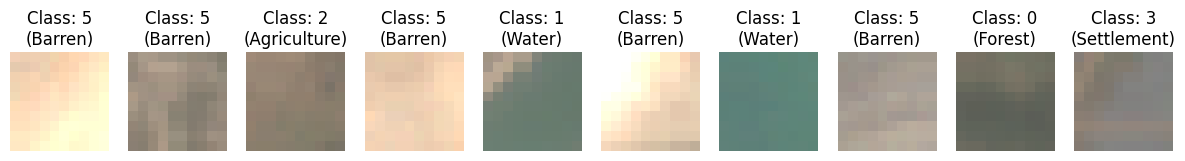

In [30]:
# STEP 5: LOAD THE NPZ FILE AND INSPECT ITS CONTENTS
# ==============================================================================
try:
    print(f"\nLoading data from: {processed_data_path}")
    # Load the entire .npz file into a data object
    data = np.load(processed_data_path)

    # --- Print a summary of the contents ---
    print("\n--- File Contents Summary ---")
    # The .files attribute shows the names of the arrays saved in the file
    print(f"Arrays found in file: {data.files}")

    # Access the individual arrays using their names as keys
    X_data = data['x_data']
    y_data = data['y_data']

    # Print the shapes to confirm the dimensions
    print(f"Shape of image patches array ('x_data'): {X_data.shape}")
    print(f"Shape of labels array ('y_data'): {y_data.shape}")
    print("-----------------------------\n")
    print("Displaying a few sample patches from the dataset...\n")

    # Define your class names and colors for the plot titles
    # Make sure this matches the order of your class IDs (0, 1, 2, ...)
    class_names = [
        'Forest',       # 0
        'Water',        # 1
        'Agriculture',  # 2
        'Settlement',   # 3
        'Mining',       # 4
        'Barren'        # 5
    ]

    # Function to normalize bands for display (same as before)
    def normalize_for_display(patch):
        # Select the Red, Green, Blue bands for a true-color view
        # Assuming the order is B2, B3, B4, ... -> we need bands at index 0, 1, 2
        # If your band order is different, you may need to change these indices
        red = patch[:, :, 2] # B4 is the 3rd band
        green = patch[:, :, 1] # B3 is the 2nd band
        blue = patch[:, :, 0] # B2 is the 1st band

        rgb = np.dstack((red, green, blue))

        # Scale for viewing
        rgb_scaled = (rgb / 4000.0).astype(np.float32)
        return np.clip(rgb_scaled, 0, 1)

    # Create a plot with a few sample images
    plt.figure(figsize=(15, 7))
    num_samples_to_show = 10
    for i in range(num_samples_to_show):
        # Choose a random index to display
        idx = np.random.randint(0, len(X_data))

        # Get the patch and its label
        image_patch = X_data[idx]
        label_id = y_data[idx]

        # Prepare the image for plotting
        display_patch = normalize_for_display(image_patch)

        # Create a subplot for each image
        ax = plt.subplot(1, num_samples_to_show, i + 1)
        plt.imshow(display_patch)
        plt.title(f"Class: {label_id}\n({class_names[label_id]})")
        plt.axis("off")

    plt.show()

except FileNotFoundError:
    print(f"\nERROR: The file was not found at '{processed_data_path}'.")
    print("Please check the path and make sure the file exists.")
except Exception as e:
    print(f"An error occurred: {e}")